# Relevant Libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Load in data

Some of the code has been taken/modified from https://www.kaggle.com/code/adrienmorel97/eda-lightgbm-optuna-1-0644-v1.
I had similar ideas for the data exploration, and didn't think it was necessary to rewrite it.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


## Data exploration

In [3]:
print(f"shape of data {df_train.shape} \n")

# Select categorical and numerical columns
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns

print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

shape of data (1200000, 21) 


Categorical Columns: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Numerical Columns: ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']


In [4]:
for column in categorical_columns:
    num_unique = df_train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Gender' has 2 unique categories.
'Marital Status' has 3 unique categories.
'Education Level' has 4 unique categories.
'Occupation' has 3 unique categories.
'Location' has 3 unique categories.
'Policy Type' has 3 unique categories.
'Policy Start Date' has 167381 unique categories.
'Customer Feedback' has 3 unique categories.
'Smoking Status' has 2 unique categories.
'Exercise Frequency' has 4 unique categories.
'Property Type' has 3 unique categories.


In [5]:
target_column = 'Premium Amount'

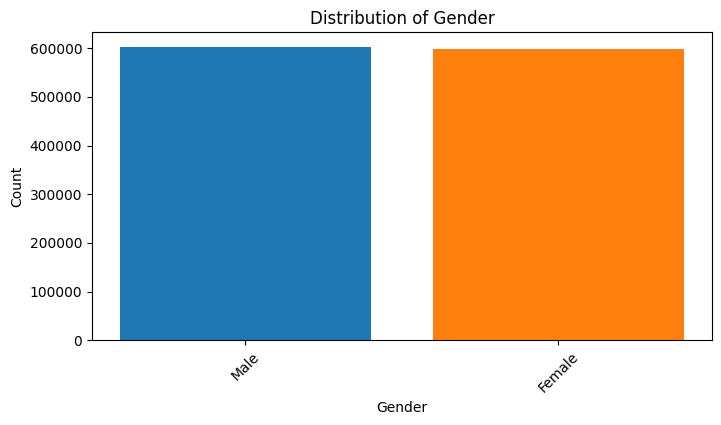

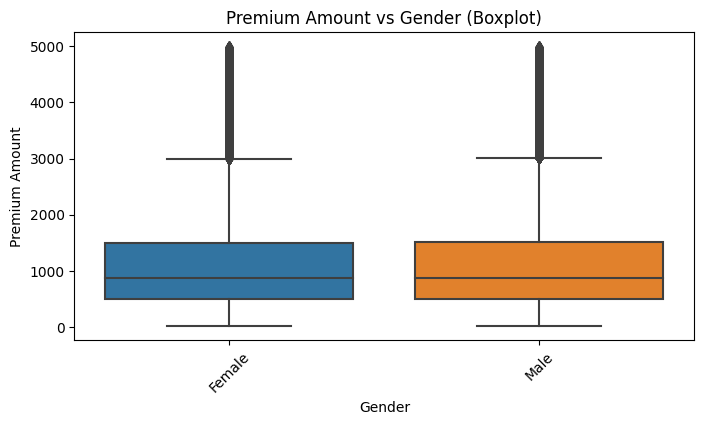

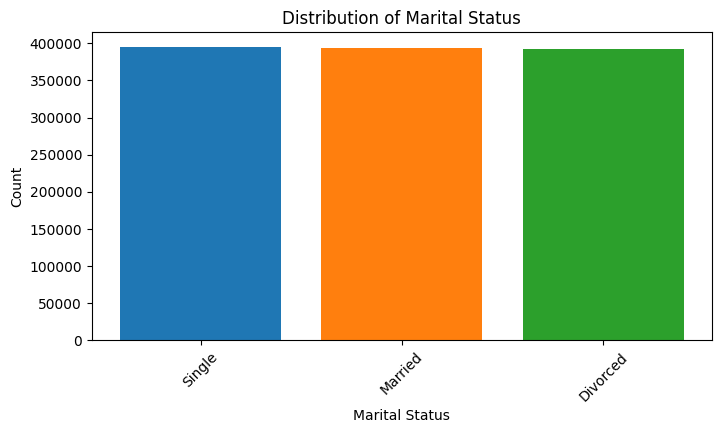

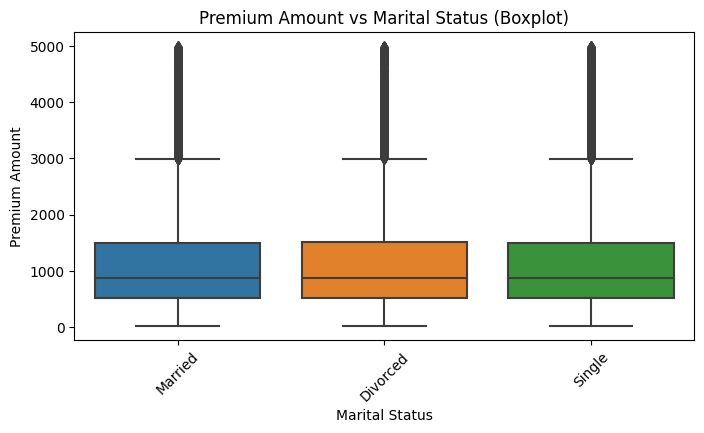

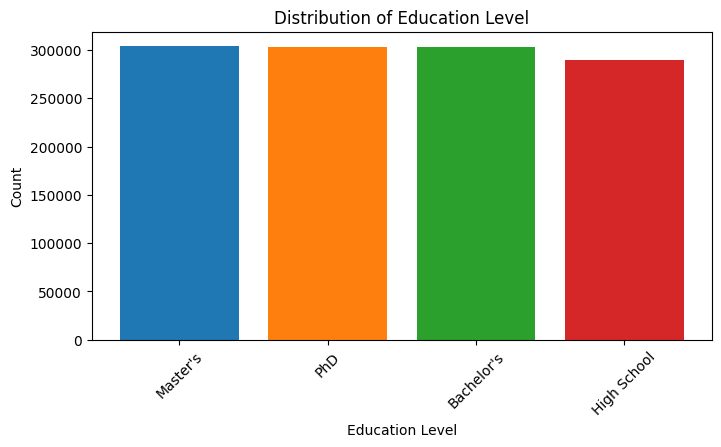

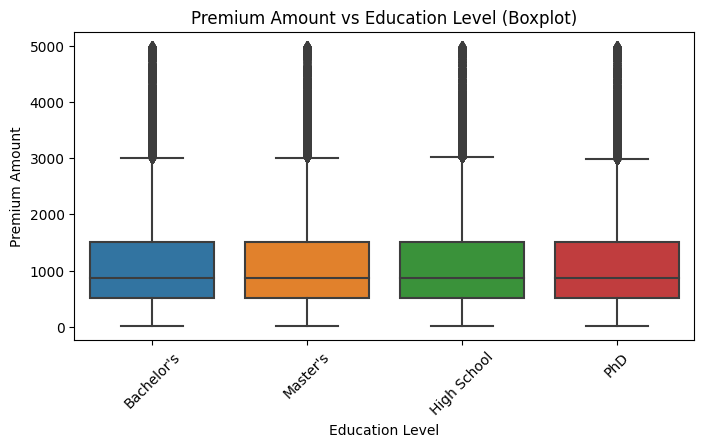

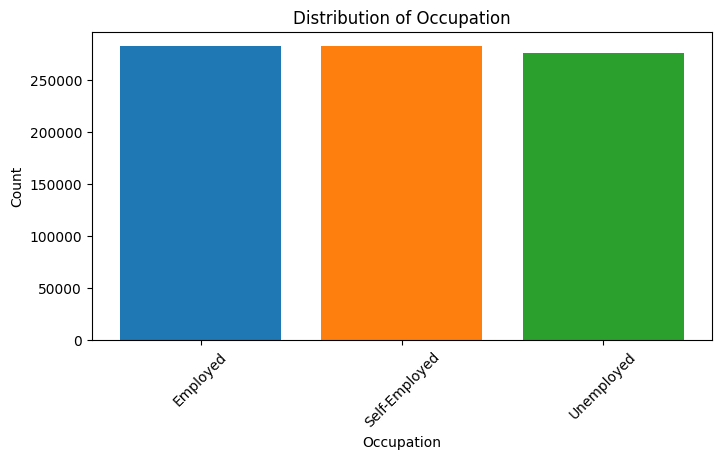

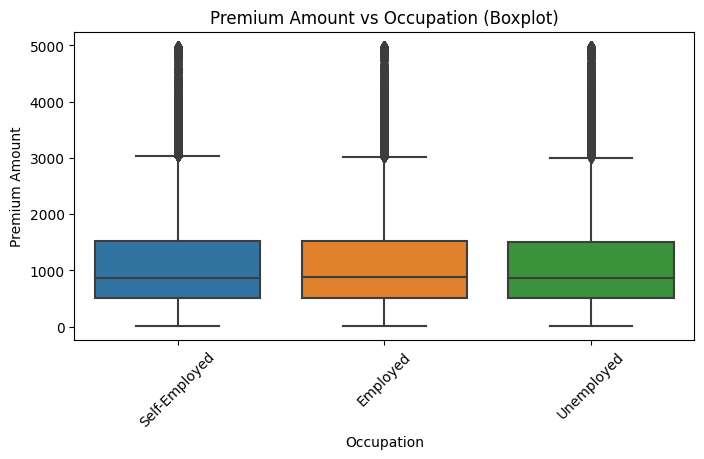

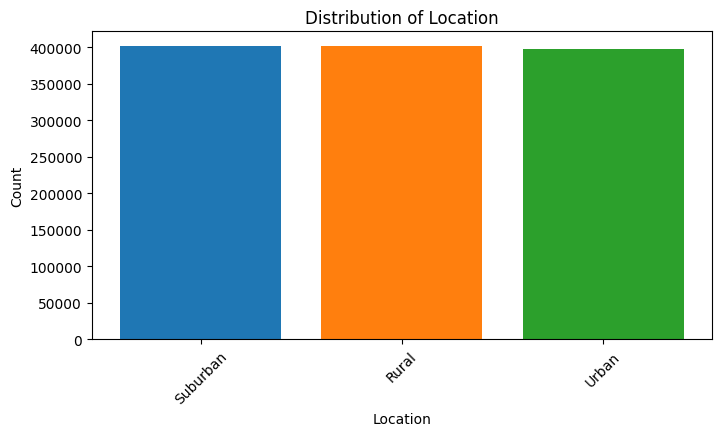

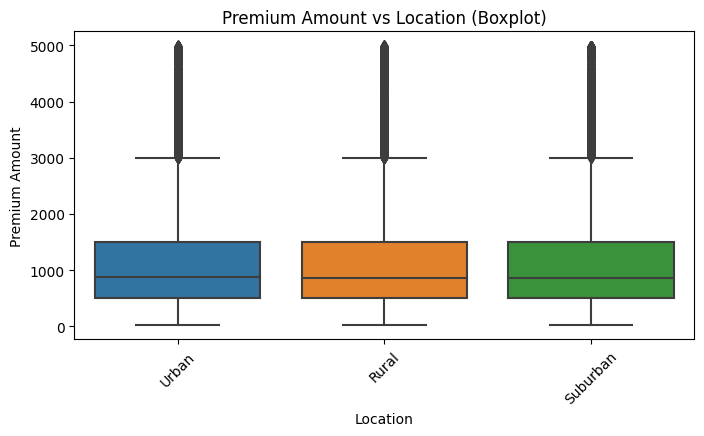

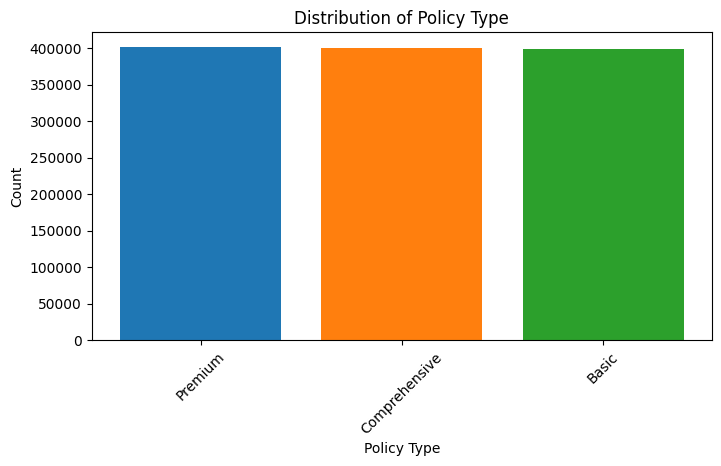

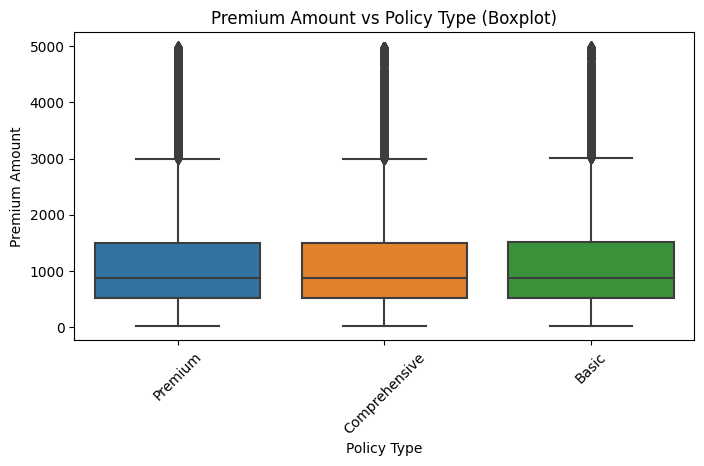

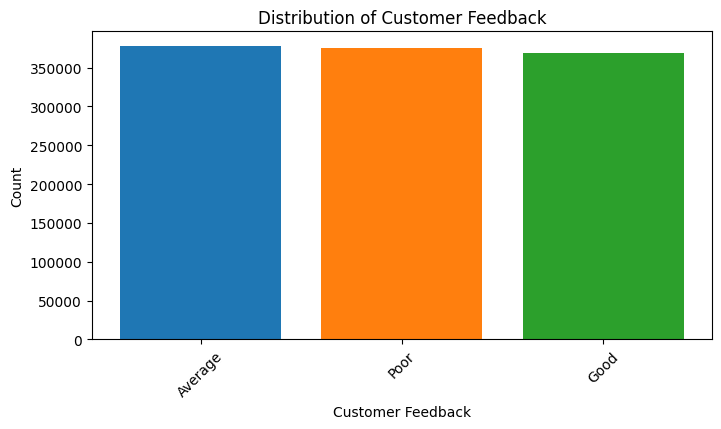

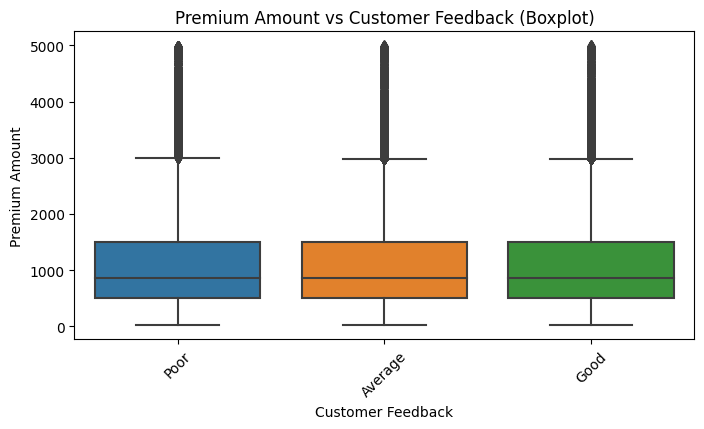

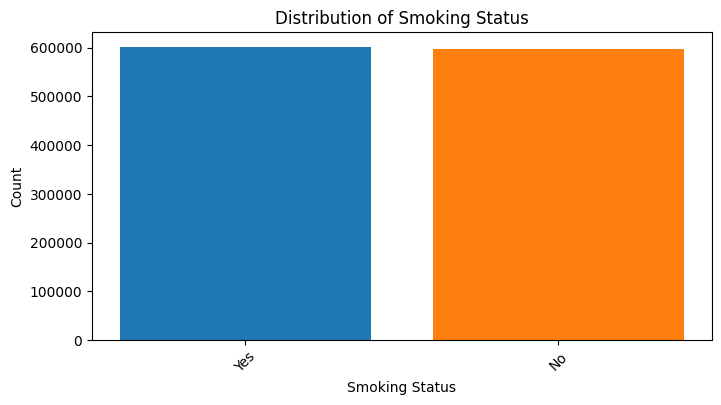

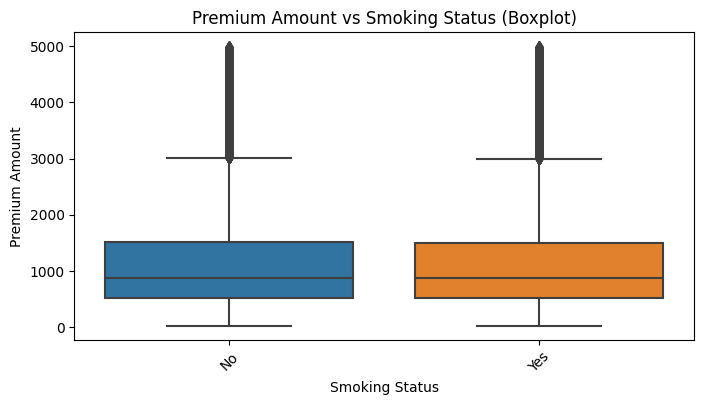

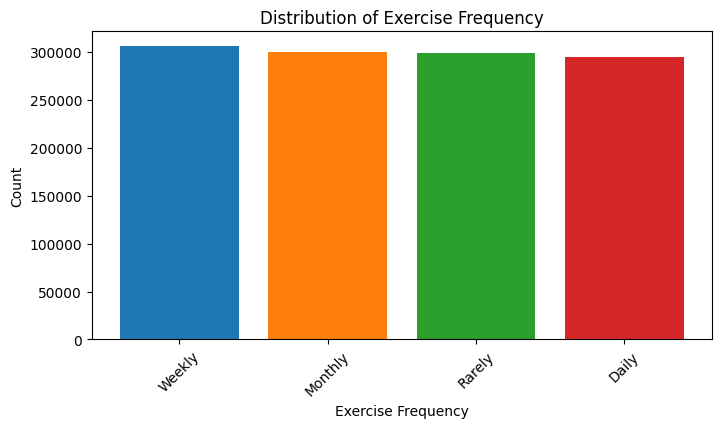

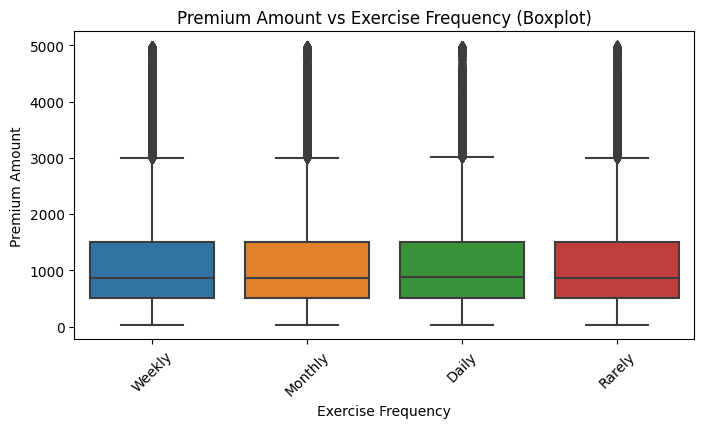

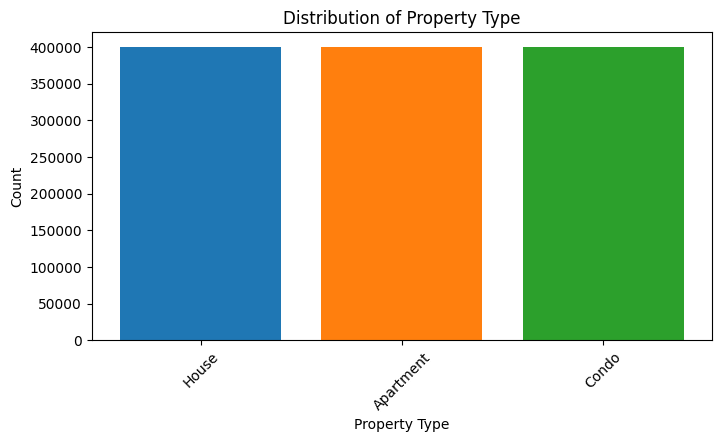

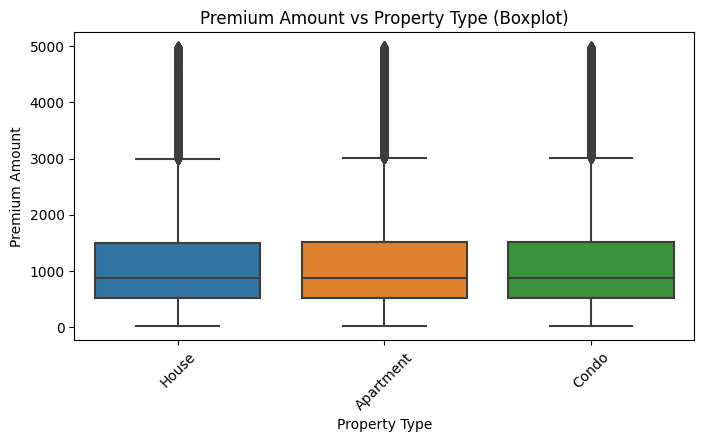

In [6]:
for col in categorical_columns:
    if col == 'Policy Start Date': 
        continue
        
    unique_categories = df_train[col].nunique()
    palette = sns.color_palette('tab10', unique_categories)  
    
    plt.figure(figsize=(8, 4))
    category_counts = df_train[col].value_counts()
    category_colors = [palette[i] for i in range(len(category_counts))]
    
    plt.bar(category_counts.index, category_counts.values, color=category_colors)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(8, 4))
    sns.boxplot(
        data=df_train, 
        x=col, 
        y=target_column, 
        palette=palette 
    )
    plt.title(f'{target_column} vs {col} (Boxplot)')
    plt.xlabel(col)
    plt.ylabel(target_column)
    plt.xticks(rotation=45)
    plt.show()

Each categorical column is evenly distributed

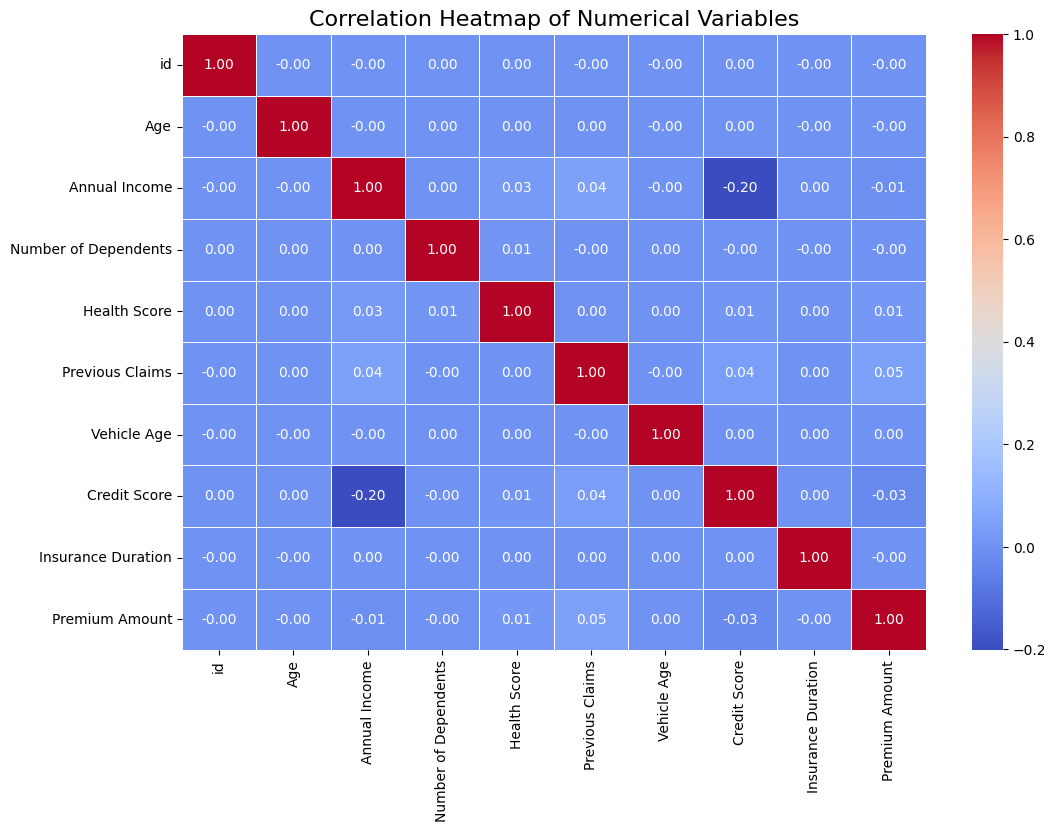

In [7]:
# Calculate the correlation matrix
correlation_matrix = df_train[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

There is nothing really that significant here. No numerial features seems to have a linear relationship with Premium Amount. Elsewhere, credit score and annual income have a slight negative correlation - doesn't seem intuitive. 

So far, looks like non linear models must be considered.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and 

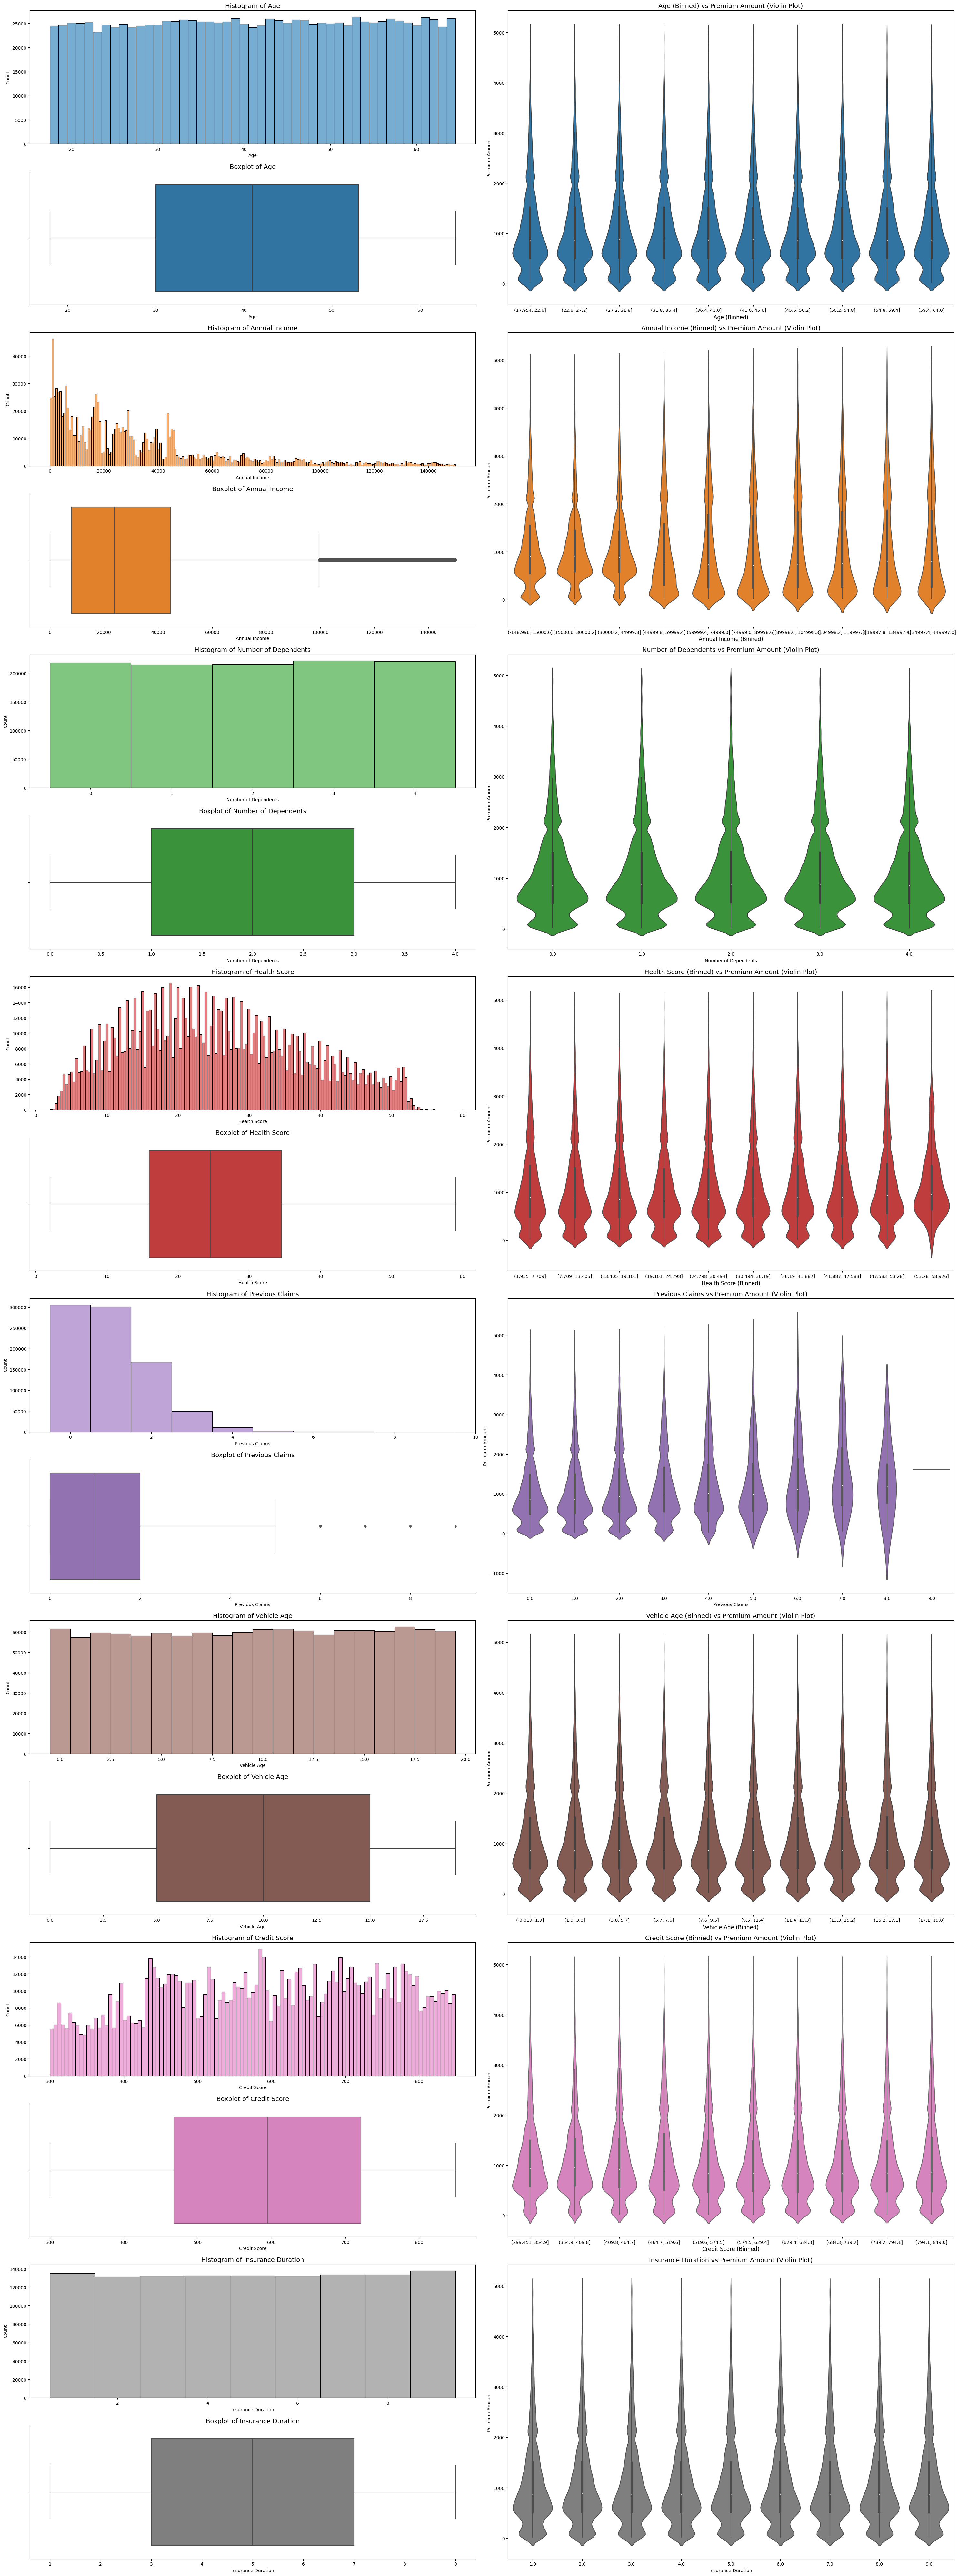

In [8]:
# Copy of the DataFrame and target column
df_binned = df_train.copy()
target_column = 'Premium Amount'

# Define numerical columns to exclude 'id' and 'Premium Amount'
filtered_numerical_columns = [col for col in numerical_columns if col not in ['id', target_column]]

# Color palette for the columns
palette = sns.color_palette('tab10', len(filtered_numerical_columns))
color_dict = dict(zip(filtered_numerical_columns, palette))

# Grid for subplots
fig = plt.figure(figsize=(30, 10 * len(filtered_numerical_columns)))
gs = gridspec.GridSpec(2 * len(filtered_numerical_columns), 2, figure=fig)

for i, column in enumerate(filtered_numerical_columns):

    # Determine if column is discrete
    discrete = df_train[column].nunique() <= 50

    # Plot histogram
    ax_hist = fig.add_subplot(gs[2 * i, 0])
    sns.histplot(
        data=df_train, x=column, fill=True, common_norm=False, alpha=0.6,
        linewidth=0.8, color=color_dict[column], ax=ax_hist, discrete=discrete
    )
    ax_hist.set_title(f'Histogram of {column}', fontsize=14)

    # Plot boxplot
    ax_box = fig.add_subplot(gs[2 * i + 1, 0])
    sns.boxplot(data=df_train, x=column, ax=ax_box, color=color_dict[column])
    ax_box.set_title(f'Boxplot of {column}', fontsize=14)
    sns.despine(ax=ax_box)

    # Violin plot or binned violin plot
    ax_conditional = fig.add_subplot(gs[2 * i:2 * i + 2, 1])
    if df_train[column].nunique() <= 10:
        sns.violinplot(data=df_train, x=column, y=target_column, ax=ax_conditional, 
                       color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} vs {target_column} (Violin Plot)', fontsize=14)
    else:
        df_binned['Binned Column'] = pd.cut(df_train[column], bins=10)
        sns.violinplot(data=df_binned, x='Binned Column', y=target_column, ax=ax_conditional, 
                       color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} (Binned) vs {target_column} (Violin Plot)', fontsize=14)
        ax_conditional.set_xlabel(f'{column} (Binned)', fontsize=12)

plt.tight_layout()
plt.show()

So far, data looks like it will require a non linear model. I will attempt with a neural network.

# Preprocessing
Replace missing values with mean where possible.

Handle policy start data by converting dates into cylical features.

One hot encode categorical features.

Normalise data.